# SOLAQUA dataprocessing 

Here we convert "raw"-.bag files into desired sonar images. They are also exported

# (Optional) List Topics

In [1]:
from collections import defaultdict 
from rosbags.highlevel import AnyReader
from pathlib import Path
import numpy as np
import cv2
import re

# Change these two lines to switch dataset
DATA_BAG  = Path("data/bags/2024-08-20_13-57-42_data.bag")   # sensor data
VIDEO_BAG = Path("data/bags/2024-08-20_13-57-42_video.bag")  # camera and sonar video
VIDEO_FRAME = 0

print(f"Using data bag : {DATA_BAG.resolve()}")
print(f"Using video bag: {VIDEO_BAG.resolve()}")




def human_hz(count, duration_s):
    if count == 0 or duration_s <= 0:
        return 0.0
    return count / duration_s

for bag in [DATA_BAG, VIDEO_BAG]:
    print(f"\n=== {bag.name} ===")
    if not bag.exists():
        print("  (missing)")
        continue

    counts = defaultdict(int)
    first_ts = defaultdict(lambda: None)
    last_ts  = defaultdict(lambda: None)
    types = {}

    with AnyReader([bag]) as r:
        for c in r.connections:
            types[c.topic] = c.msgtype
        for conn, ts, _ in r.messages():
            t = conn.topic
            counts[t] += 1
            if first_ts[t] is None or ts < first_ts[t]:
                first_ts[t] = ts
            if last_ts[t] is None or ts > last_ts[t]:
                last_ts[t] = ts

    if not counts:
        print("  (no messages)")
        continue

    col_topic = max(len(t) for t in counts.keys())
    col_type  = max(len(types.get(t, "")) for t in counts.keys())
    header = f"{'TOPIC'.ljust(col_topic)}  {'TYPE'.ljust(col_type)}  COUNT    START(ns)          END(ns)            DURATION(s)  ~HZ"
    print(header)
    print("-" * len(header))

    for t in sorted(counts.keys()):
        n = counts[t]
        t0 = first_ts[t]
        t1 = last_ts[t]
        dur_s = (t1 - t0) / 1e9 if (t0 is not None and t1 is not None) else 0.0
        hz = human_hz(n, dur_s)
        print(
            f"{t.ljust(col_topic)}  "
            f"{types.get(t,'').ljust(col_type)}  "
            f"{str(n).rjust(5)}    "
            f"{str(t0).rjust(16)}  "
            f"{str(t1).rjust(16)}  "
            f"{dur_s:11.3f}  {hz:5.2f}"
        )

Using data bag : /cluster/home/henrban/SOLAQUA-UOD/solaqua/data/bags/2024-08-20_13-57-42_data.bag
Using video bag: /cluster/home/henrban/SOLAQUA-UOD/solaqua/data/bags/2024-08-20_13-57-42_video.bag

=== 2024-08-20_13-57-42_data.bag ===
TOPIC                                     TYPE                                     COUNT    START(ns)          END(ns)            DURATION(s)  ~HZ
--------------------------------------------------------------------------------------------------------------------------------------------------
/bluerov2/alive                           std_msgs/msg/Float32                       155    1724155067444230600  1724155144060540800       76.616   2.02
/bluerov2/armed                           std_msgs/msg/Float32                       155    1724155067237915400  1724155144060590500       76.823   2.02
/bluerov2/battery                         messages/msg/BatteryStatus                  72    1724155068909052000  1724155143540579800       74.632   0.96
/bluerov2/mo

# Sonar data processing

What we want is raw sonar data processed to RGB images (and later grayscale that looks similar to cfc_gray).

### Setup 

In [2]:
from __future__ import annotations
from dataclasses import dataclass
from typing import Dict
import hashlib
import json

from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt



In [3]:
SONAR_IMAGES_CONFIG = {
    # ===== data mapping. From matrix to real-values
    "fov_deg": 120.0,     # field of view. in degrees. 0 in middle (+-60)
    "range_min_m": 0.0, 
    "range_max_m": 20.0,    # depth of data

    "transpose_M": False,   # we transpose the matrix (swap H and W)
    "flipX_M": False,    # we flip the beam angles 
    "flipY_M": False,    # we flip the range angles

    "enhancer_type":"cfc_style", # "default" is the enhance_intensity(), and xx is the cfc_style is the enhance_sonar_dataset_style()

    # ===== default enhancement
    "enh_scale": "db",            # db | log | sqrt | lin
    "enh_tvg": "amplitude",       # amplitude | none
    "enh_alpha_db_per_m": 0.0,
    "enh_eps_log": 1e-5,
    "enh_r0": 1e-6,
    "enh_p_low": 1.0,
    "enh_p_high": 99.5,
    "enh_gamma": 0.9,
    "enh_zero_aware": True,

    # ===== custom enhancement
    "ds_geo_exponent": 1.0,      # geometric spreading comp (× r^g)
    "ds_alpha_db_per_m": 0.0,    # absorption gain [dB/m]; try 0.02..0.06 if needed
    "ds_alpha_r0": 0.0,          # start distance for absorption comp

    "ds_bg_percentile": 60.0,    # per-row baseline removal
    "ds_bg_scale": 1.0,

    "ds_eps_log": 1e-5,          # log epsilon
    "ds_p_low": 2.0,             # robust stretch
    "ds_p_high": 99.7,           # reduces extreme stretching, less whitness
    "ds_gamma": 0.9,             # tone curve (0.85–1.0 typical)
    "ds_max_white_cap": 0.85,       # max cap for whiteness. 1 keeps completely white

    "ds_soft_floor": 0.25,       # lifts background toward mid-gray (0 disables)

    "ds_noise_enabled": True,
    "ds_noise_std": 0.10,       # try 0.01–0.10
    "ds_noise_seed": None,      # or an int for reproducibility


    # ===== visualization polar
    "cmap_raw": "viridis",
    "cmap_enh": "gray",
    "figsize": (6, 5.6),
    "display_range_min_m": 0.2, # how deep we show 
    "display_range_max_m": 5.0, # how deep we show

    # ===== cone view 
    "img_w": 1200,
    "img_h": 700,
    "bg_color": "#4b4b4b",
    "rotate_deg": 0.0,  
    "coneview_range_min_m": 0.2,
    "coneview_range_max_m": 8.0,
    "coneview_angle_min_deg": -45.0,
    "coneview_angle_max_deg": 45.0,
}




### Load data

In [4]:
from pathlib import Path
from utils.loader import load_sonoptix_frame_from_bag

DATA_BAG  = Path("data/bags/2024-08-20_13-57-42_data.bag")   
VIDEO_BAG = Path("data/bags/2024-08-20_13-57-42_video.bag")  
VIDEO_FRAME = 0

M_raw, t_ns = load_sonoptix_frame_from_bag(VIDEO_BAG, VIDEO_FRAME)  # returns M_raw and timestamp
print("loaded:", M_raw.shape, M_raw.dtype, ". min..max:", float(M_raw.min()), float(M_raw.max()))
print("M_raw:")
print(M_raw)
print("timestamp: ", t_ns)  

loaded: (1024, 256) float32 . min..max: 0.0 59.0
M_raw:
[[ 6.  6.  7. ...  8.  8.  5.]
 [ 8.  9.  9. ... 11. 11.  9.]
 [ 5.  6.  7. ...  9. 10.  9.]
 ...
 [ 0.  0.  0. ...  0.  0.  0.]
 [ 0.  0.  0. ...  0.  0.  0.]
 [ 0.  0.  0. ...  0.  0.  0.]]
timestamp:  1724155065046873200



#### Plot raw and enhanced data, Polar from

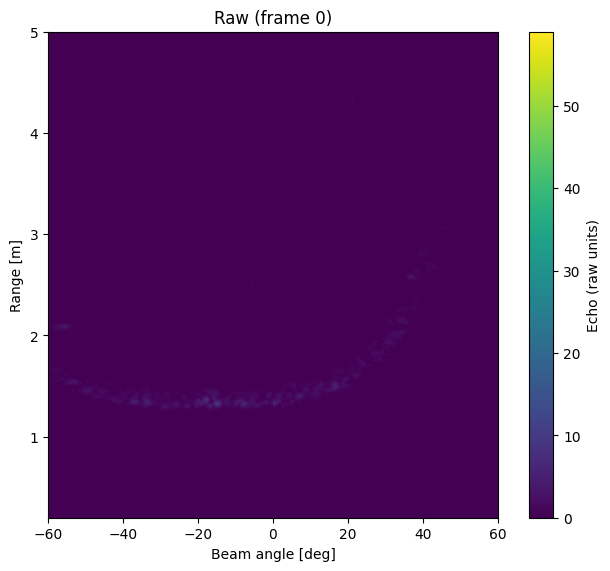

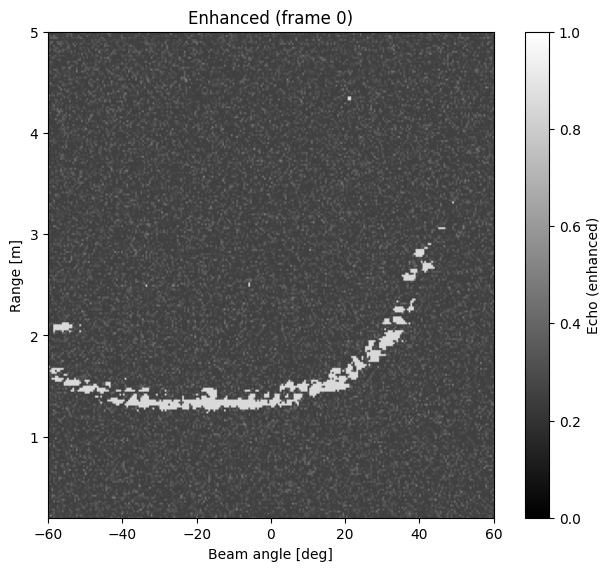

In [5]:
from utils.sonar_visualization import plot_raw_frame, plot_enhanced_frame, enhance_intensity, enhance_cfc_style


# fig = plot_raw_and_enhanced(M_raw, VIDEO_FRAME, SONAR_VIS_DEFAULTS)
fig1 = plot_raw_frame(M_raw, VIDEO_FRAME, SONAR_IMAGES_CONFIG)
fig2 = plot_enhanced_frame(M_raw, VIDEO_FRAME, SONAR_IMAGES_CONFIG, enhancer=enhance_cfc_style)
plt.show()


### Plot Cone display

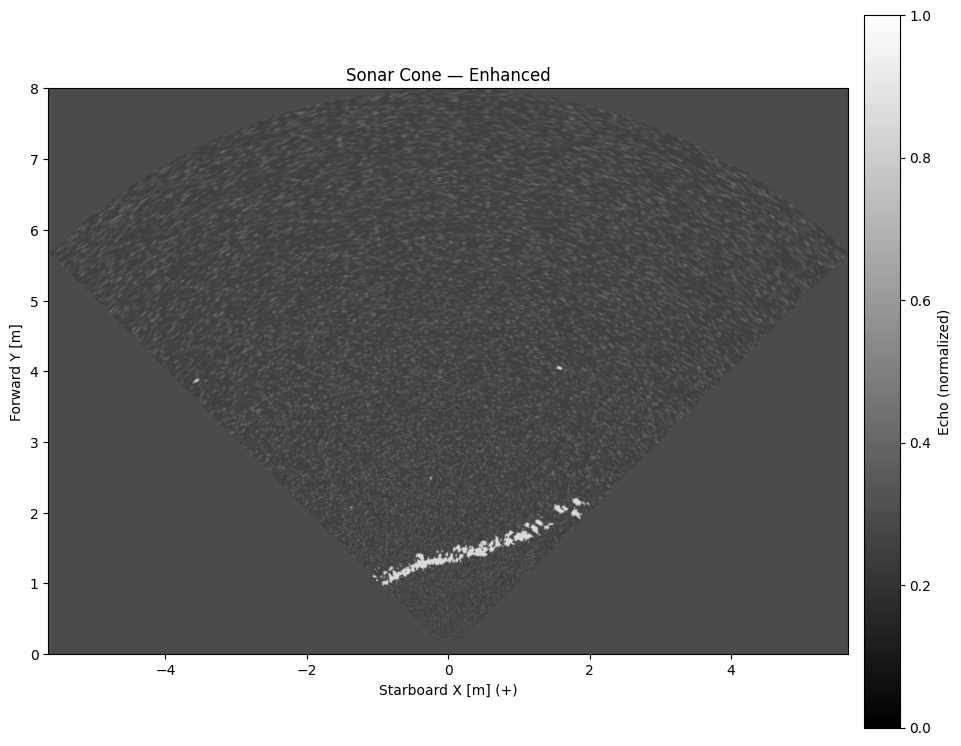

In [6]:
from utils.sonar_visualization import plot_cone_view, enhance_intensity, enhance_cfc_style


fig_cone = plot_cone_view(
    M_raw, 
    SONAR_IMAGES_CONFIG,
    use_enhanced=True,
    enhancer=enhance_cfc_style,   
)
plt.show()


# Export data (remember to set output name)



In [7]:
# from utils.sonar_visualization import save_cone_view_image, enhance_cfc_style

# save_cone_view_image(
#     M_raw,
#     SONAR_IMAGES_CONFIG,
#     out_path="exports/processed_images/001_frame.png",
#     use_enhanced=True,
#     enhancer=enhance_cfc_style,
# )


In [8]:
from pathlib import Path
from utils.loader import load_sonoptix_frame_from_bag
from utils.sonar_visualization import save_cone_view_image, enhance_cfc_style
import numpy as np
from tqdm import tqdm

# ----------------------------
# SETTINGS
# ----------------------------
bag_stem = VIDEO_BAG.stem.replace("_video", "")

OUT_DIR = Path("data/exports/sonar") / bag_stem / "cfc_style" / "images"  ## CHANGE HERE after bag_stem


# Range of frames to export
START_FRAME = 0
END_FRAME   = 1249     # change this to however many frames your bag has
STEP        = 1

# Enhancer to use
ENHANCER = enhance_cfc_style

# Your sonar config dict
CFG = SONAR_IMAGES_CONFIG
# ----------------------------


OUT_DIR.mkdir(parents=True, exist_ok=True)

for frame_idx in tqdm(range(START_FRAME, END_FRAME, STEP), desc="Exporting frames"):

    try:
        M_raw, t_ns = load_sonoptix_frame_from_bag(VIDEO_BAG, frame_idx)
    except Exception as e:
        tqdm.write(f"⚠️ Could not load frame {frame_idx}: {e}")
        continue

    # skip empty frames
    if M_raw is None or not isinstance(M_raw, np.ndarray):
        tqdm.write(f"⚠️ Empty frame {frame_idx}")
        continue

    # Output filename = timestamp
    out_path = OUT_DIR / f"{t_ns}.jpg"


    save_cone_view_image(
        M_raw,
        CFG,
        out_path=out_path,
        use_enhanced=True,
        enhancer=ENHANCER,
    )

print("✅ Finished exporting all frames.")


Exporting frames:   0%|          | 0/1249 [00:00<?, ?it/s]

Exporting frames: 100%|██████████| 1249/1249 [23:08<00:00,  1.11s/it]

✅ Finished exporting all frames.
